# Demand Forecasting

### Business Goal

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
%config InlineBackend.figure_format = 'retina'
plt.style.use(style='ggplot')

sns.set(rc={'figure.figsize':(12, 4)})

### Load Data

In [4]:
df_sales = pd.read_csv('/Users/shuangxu/Documents/Data Set/Demand_forecasting/Historical_sales.csv')
df_predict= pd.read_csv('/Users/shuangxu/Documents/Data Set/Demand_forecasting/Predicted_list.csv')
df_product= pd.read_csv('/Users/shuangxu/Documents/Data Set/Demand_forecasting/Product.csv')

##### Description
* df_sales has the weekly historical sales data for each product
* df_product contains the product information
* df_predict includes the products we use for demand forecasting at quarterly level

# Part 1: Data Exploration

## Part 1.1: Understand the Dataset

In [5]:
df_sales.head(3)

,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89
2,12/26/15,8391,GERMANY,WI2015,872,11137


In [6]:
df_predict.head(3)

,sku,quarter
0,8852,SU2016
1,3403,SU2016
2,7584,SU2016


In [7]:
df_product.head(3)

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726
2,12,G906,ADULT,powder,Echinacea,204,PATENT 1030


In [8]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186836 entries, 0 to 186835
Data columns (total 6 columns):
transaction_date    186836 non-null object
sku                 186836 non-null int64
location            186836 non-null object
quarter             186836 non-null object
sales_amt           186836 non-null int64
shelf_amt           186836 non-null int64
dtypes: int64(3), object(3)
memory usage: 8.6+ MB


In [9]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 7 columns):
sku            407 non-null int64
brand          407 non-null object
age            407 non-null object
formation      407 non-null object
family         407 non-null object
sales_price    407 non-null int64
specs          407 non-null object
dtypes: int64(2), object(5)
memory usage: 22.3+ KB


In [10]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 2 columns):
sku        407 non-null int64
quarter    407 non-null object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


###  1.2 Check missing values in each table

In [11]:
table_names = ['Historical_sales','Products','Predicted_list']
count = 0 
for item in [df_sales, df_product, df_predict]:
    print ('In %s talbe, the number of missing values is listed as follows:' %table_names[count])
    print (item.isnull().sum())
    count += 1
    print ('')

In Historical_sales talbe, the number of missing values is listed as follows:
transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64

In Products talbe, the number of missing values is listed as follows:
sku            0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64

In Predicted_list talbe, the number of missing values is listed as follows:
sku        0
quarter    0
dtype: int64



### 1.3 Existing products vs. New products

Note: product are defined by sku. 
* Existing products: products that are listed in Historical sales table.
* New products: products that are not listed in Historical sales table. 

In [12]:
mark_existing_product = df_predict['sku'].isin(df_sales['sku'])
mark_new_product = ~mark_existing_product

df_predict and df_sales have the same group sku in this project. 

In [13]:
print('Number of existing products: ', mark_existing_product.sum())
print('Number of new products: ', mark_new_product.sum())

Number of existing products:  320
Number of new products:  87


### 1.4 Join sales table and product table

In [14]:
df_sales.columns

Index(['transaction_date', 'sku', 'location', 'quarter', 'sales_amt',
       'shelf_amt'],
      dtype='object')

In [15]:
function = {'sales_amt':'sum', 'shelf_amt':'sum'}
sales_quarterly = df_sales.groupby(['sku','location','quarter'], as_index = False).agg(function)

In [16]:
df_sales_merged = sales_quarterly.merge(df_product, on = ['sku'], how = 'left')
print ('In merged sales talbe, the number of missing values is listed as follows:')
print(df_sales_merged.isnull().sum())

In merged sales talbe, the number of missing values is listed as follows:
sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


In [17]:
df_sales_merged.head(3)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030
2,12,SPAIN,FA2015,0,12,G906,ADULT,powder,Echinacea,204,PATENT 1030


### 1.5 Create a new product table that contains only new products 

In [18]:
new_product_predict = df_predict[~df_predict['sku'].isin(df_sales['sku'])]
new_product = df_product[df_product['sku'].isin(new_product_predict['sku'])]

In [19]:
# new products which sales data are not available 
new_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 4 to 405
Data columns (total 7 columns):
sku            87 non-null int64
brand          87 non-null object
age            87 non-null object
formation      87 non-null object
family         87 non-null object
sales_price    87 non-null int64
specs          87 non-null object
dtypes: int64(2), object(5)
memory usage: 5.4+ KB


### 1.6 Correlation analyses for numerical and categorical columns

In [20]:
df_sales_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942 entries, 0 to 6941
Data columns (total 11 columns):
sku            6942 non-null int64
location       6942 non-null object
quarter        6942 non-null object
sales_amt      6942 non-null int64
shelf_amt      6942 non-null int64
brand          6942 non-null object
age            6942 non-null object
formation      6942 non-null object
family         6942 non-null object
sales_price    6942 non-null int64
specs          6942 non-null object
dtypes: int64(4), object(7)
memory usage: 650.8+ KB


### 1.6.a. For numerical columns

In [21]:
df_sales_merged_num = df_sales_merged.select_dtypes(include=[np.number]).drop(columns = 'sku')

[MLENS] backend: threading


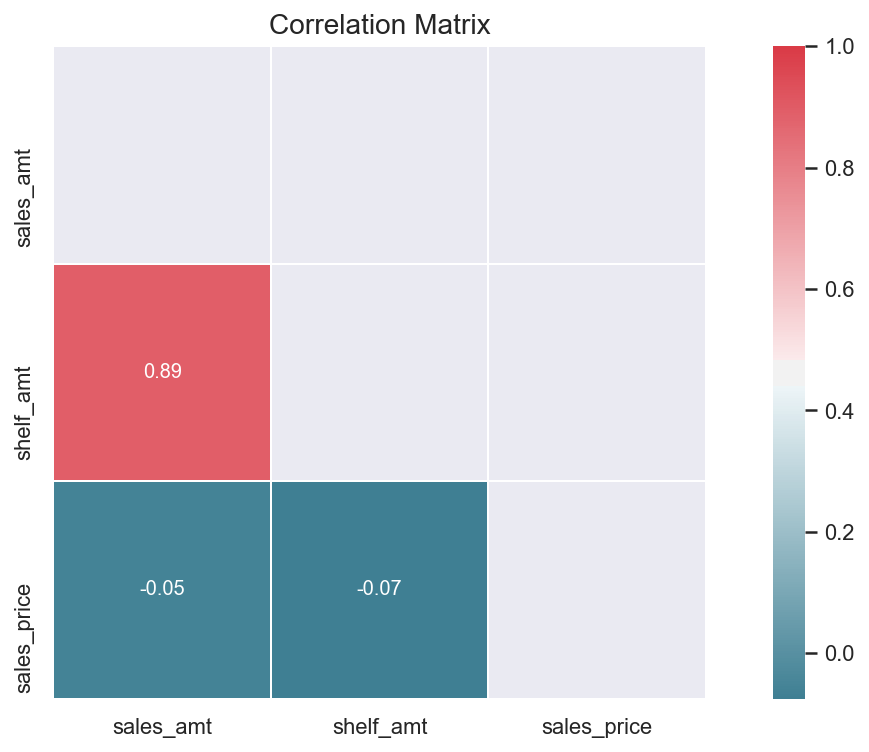

In [22]:
from mlens.visualization import corrmat
corr = df_sales_merged_num.corr()
corrmat(corr, inflate=False, figsize = (12,6))
plt.show()

### 1.6.b. For categorical columns

In [23]:
df_sales_merged_categorical = df_sales_merged.select_dtypes(exclude=[np.number])
df_sales_merged_categorical.columns

Index(['location', 'quarter', 'brand', 'age', 'formation', 'family', 'specs'], dtype='object')

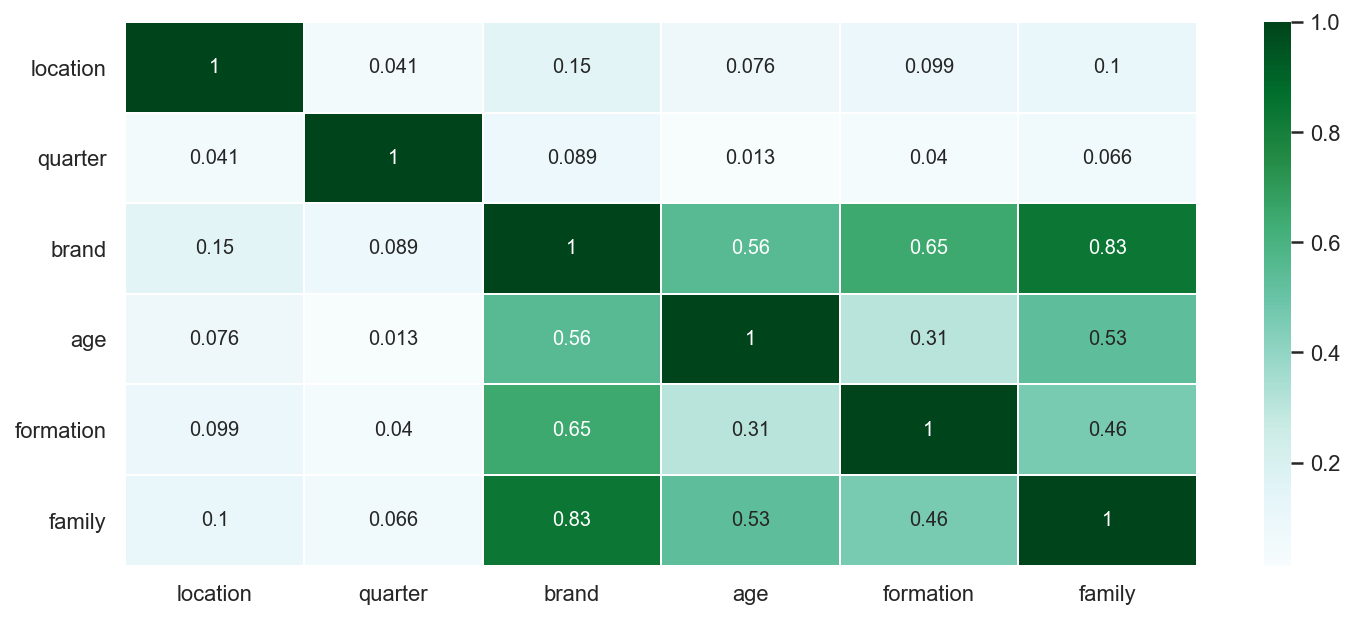

In [24]:
import scipy.stats as ss

# create categorical list without 'specs' column
categorical_list = ['location','quarter','brand','age','formation','family']

# correlation of the categorical features 
df_1 = df_sales_merged[categorical_list]
chi_square = pd.DataFrame(abs(np.random.randn(len(categorical_list),len(categorical_list))), columns= categorical_list, index = categorical_list)

# cramer V statistics for correlation between categorical features
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# chi square dataframe of categorical features
for i in categorical_list:
    temp_list = [k for k in categorical_list if k!=i]
    for j in temp_list:
        confusion_matrix = pd.crosstab(df_1[i],df_1[j])
        val = cramers_corrected_stat(confusion_matrix)
        chi_square[i][j] = float(val) # column, row
        chi_square[i][i] = 1
        
# heatmap of categorical features (exclude the complex string)
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(chi_square, cmap='BuGn', linewidths=0.5, annot=True, ax = ax)

## Exploratory data analyses

### Numerical data 

In [40]:
# plot histogram with accumulative curve
def plot_hist_cum(df, column_name, title, right_range, hist_color, logscale):
    fig, ax1 = plt.subplots(figsize = (12,4))
    ax1.hist(df[column_name].values, range(0,right_range), color = hist_color, 
             alpha = 0.7,density =False, log=logscale)
    ax1.tick_params(labelcolor=hist_color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.hist(df[column_name].values, range(0,right_range), histtype='step', color = 'grey', density = True, 
         cumulative = 1, lw = 2)
    ax2.tick_params(labelcolor='grey')
    plt.title(title)
    plt.show()
    

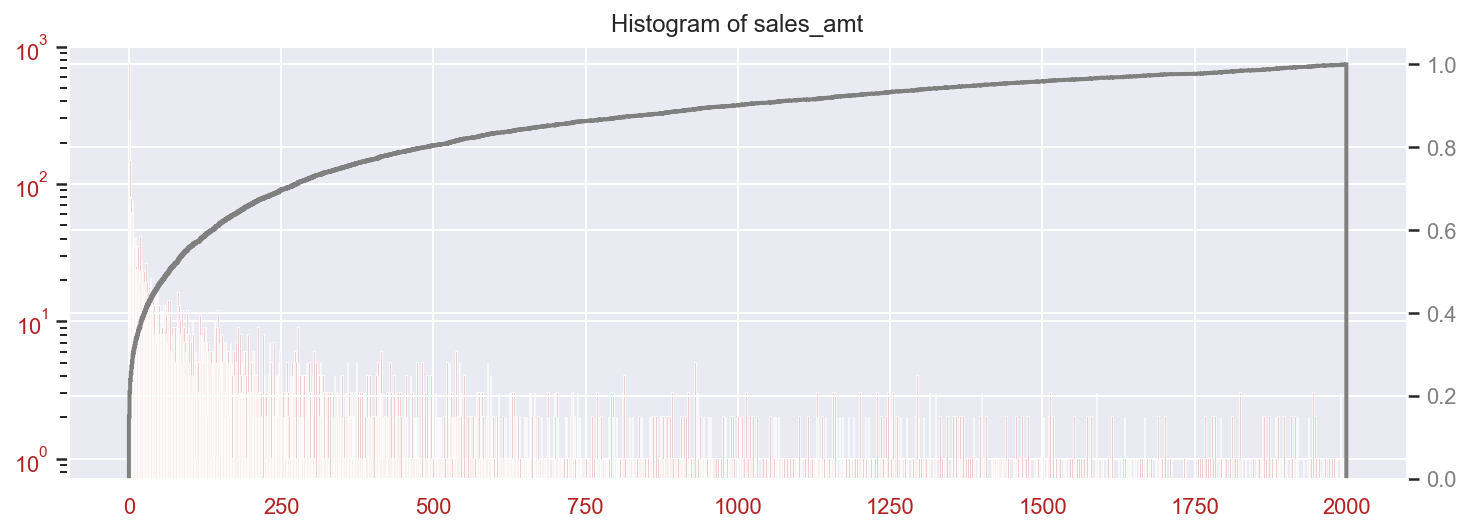

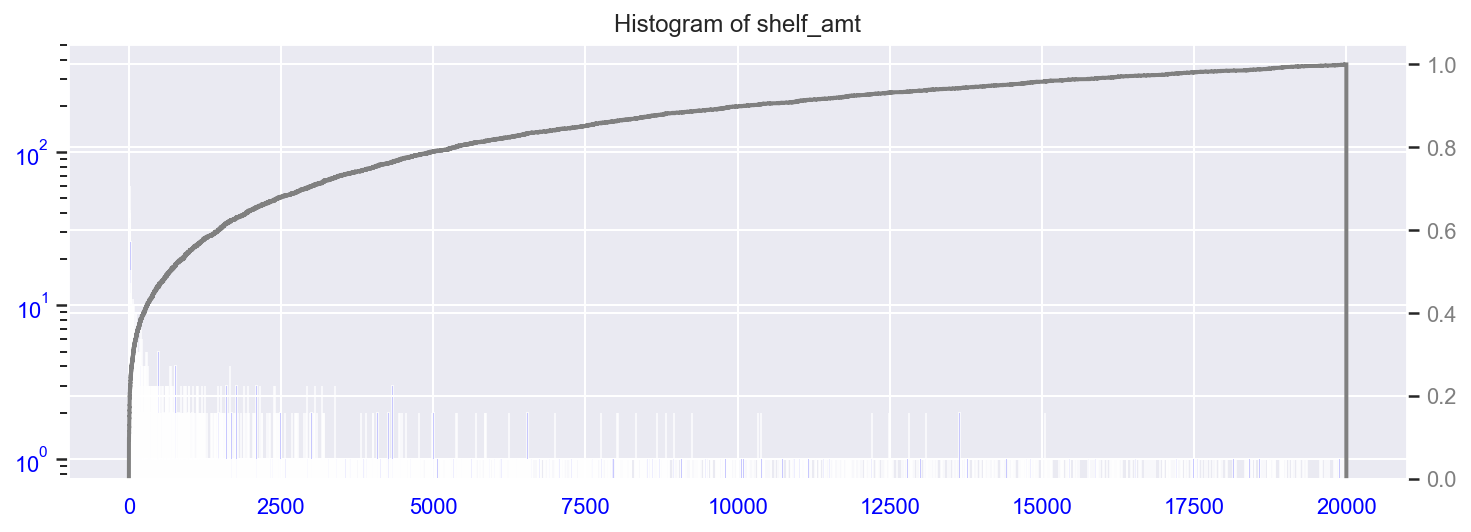

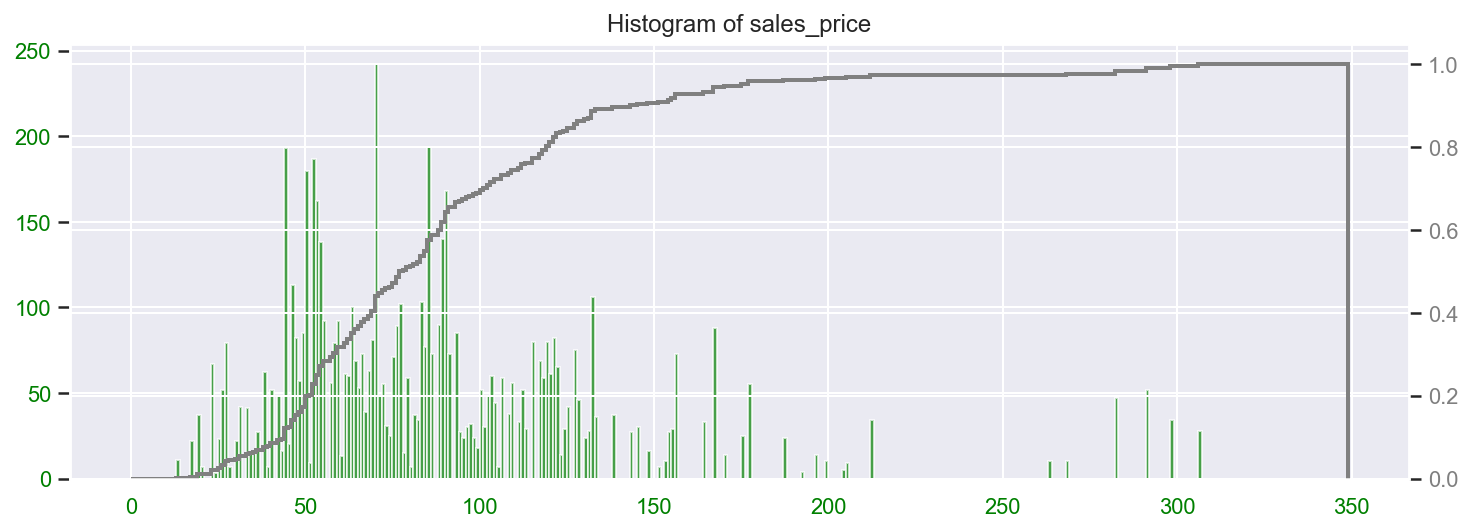

In [41]:
plot_hist_cum(df_sales_merged, 'sales_amt', 'Histogram of sales_amt', 2000, 'firebrick', True)
plot_hist_cum(df_sales_merged, 'shelf_amt', 'Histogram of shelf_amt', 20000, 'blue', True)
plot_hist_cum(df_sales_merged, 'sales_price', 'Histogram of sales_price', 350, 'green', False)

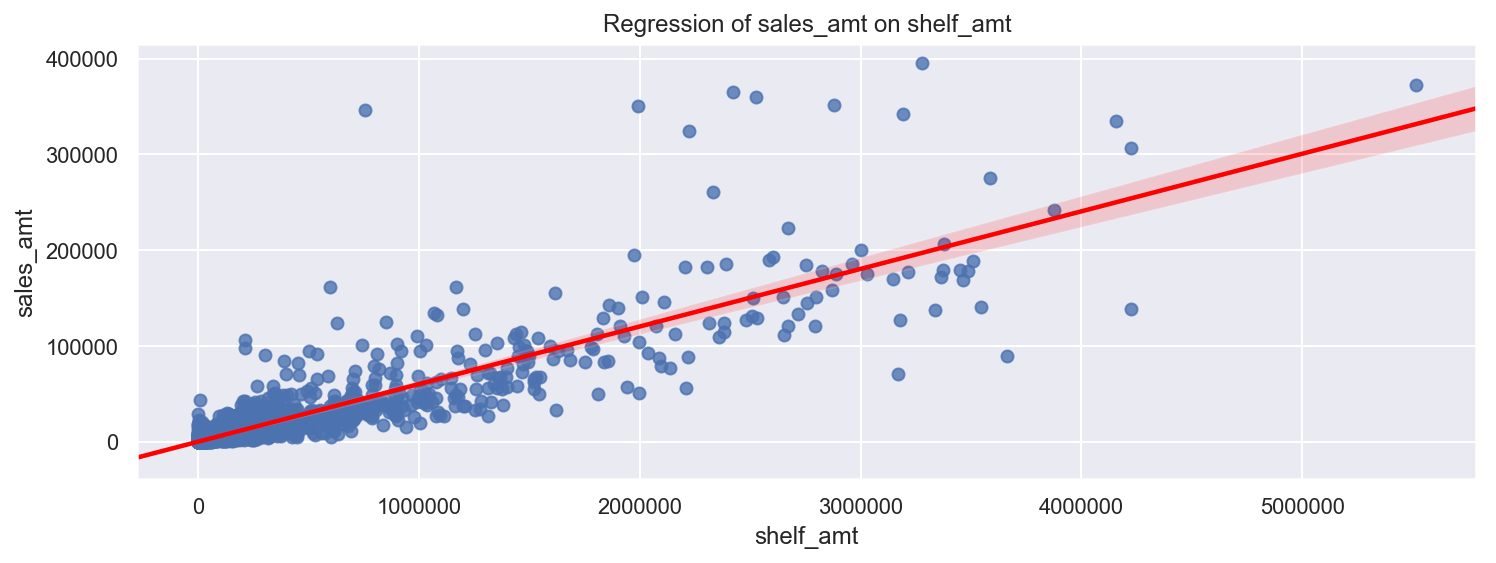

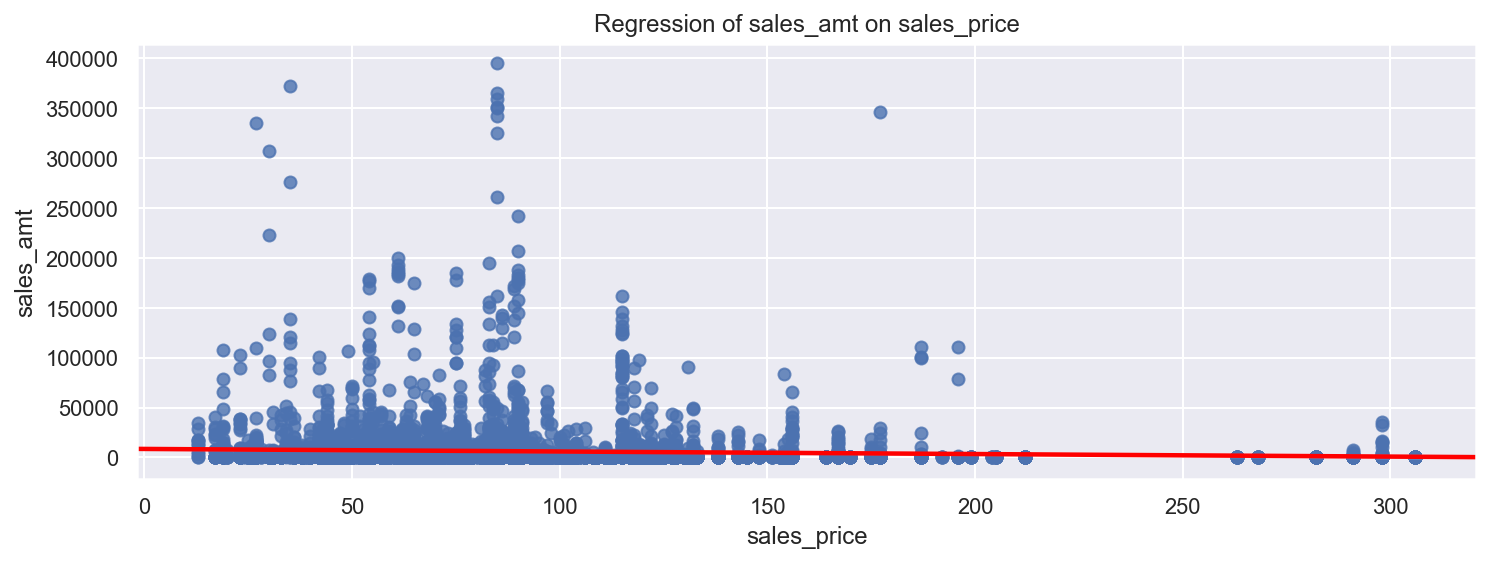

In [44]:
# plot linear dependency between the numberical and target 
sns.set(rc={'figure.figsize':(12, 4)})

reg_names = ['shelf_amt','sales_price']
count = 0 
for i in reg_names:
    sns.regplot(i,'sales_amt', data = df_sales_merged, line_kws = {'color':'red'}, label = i)
    plt.title('Regression of sales_amt on %s'%reg_names[count])
    count += 1
    plt.show()

### Categorical data 

* count the number of factors for each categorical column
* use strip plot to show correlation between categorical feature with sales

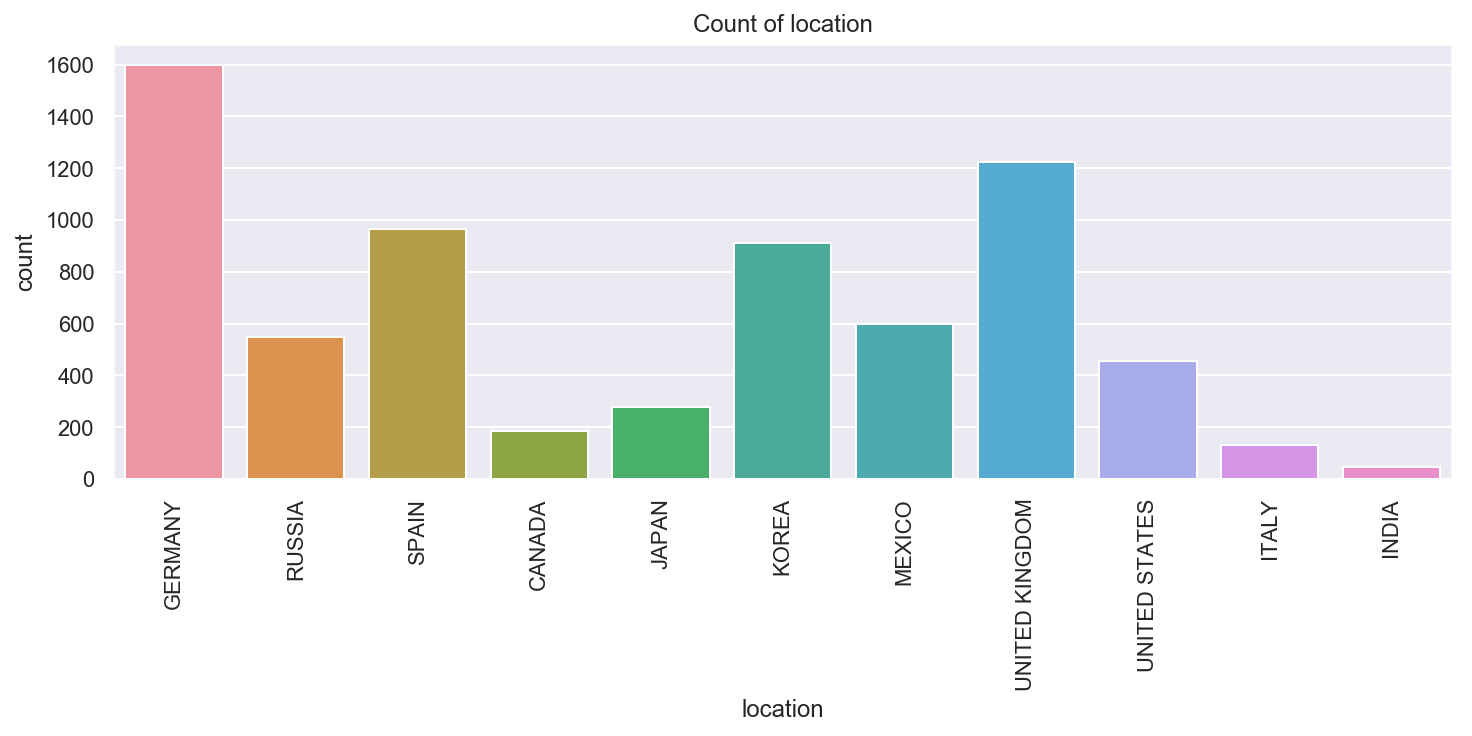

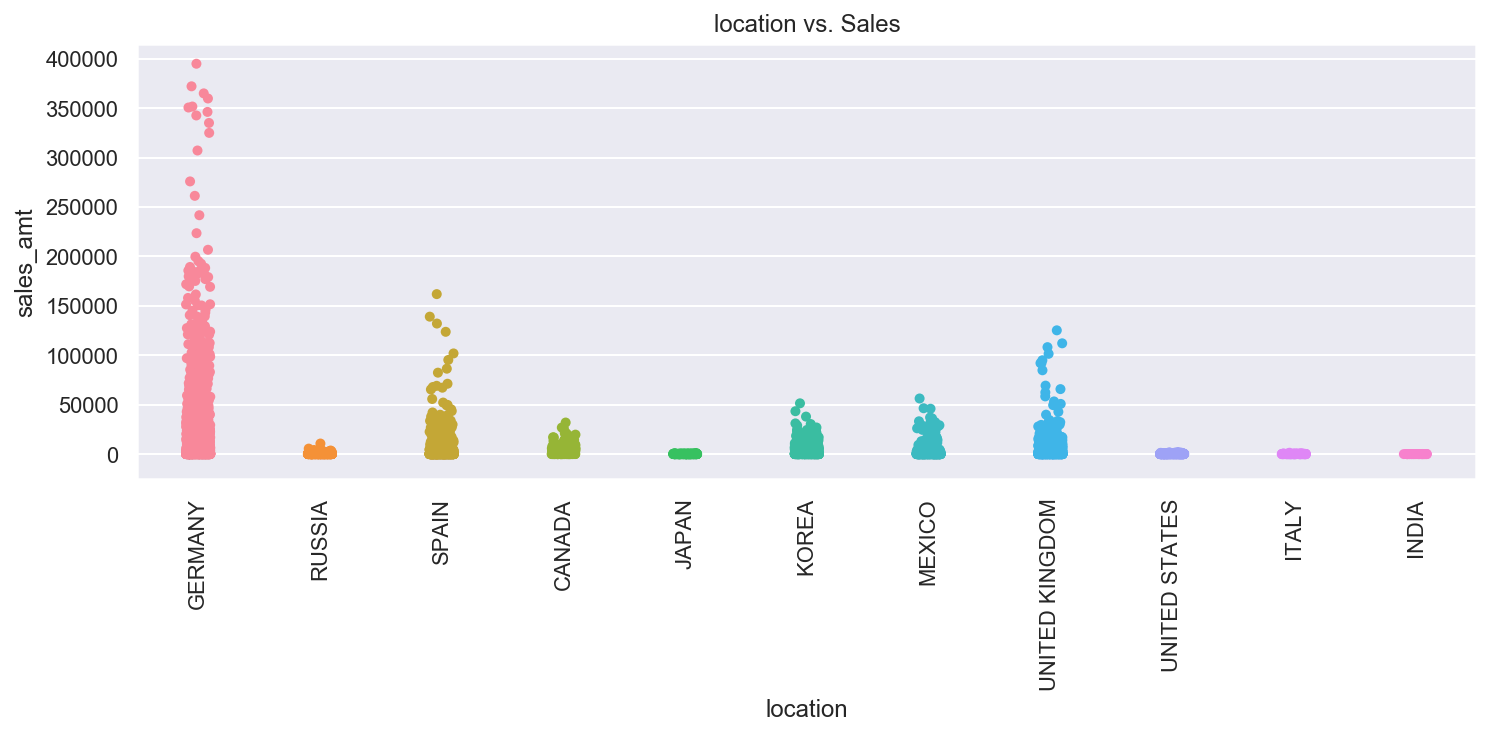

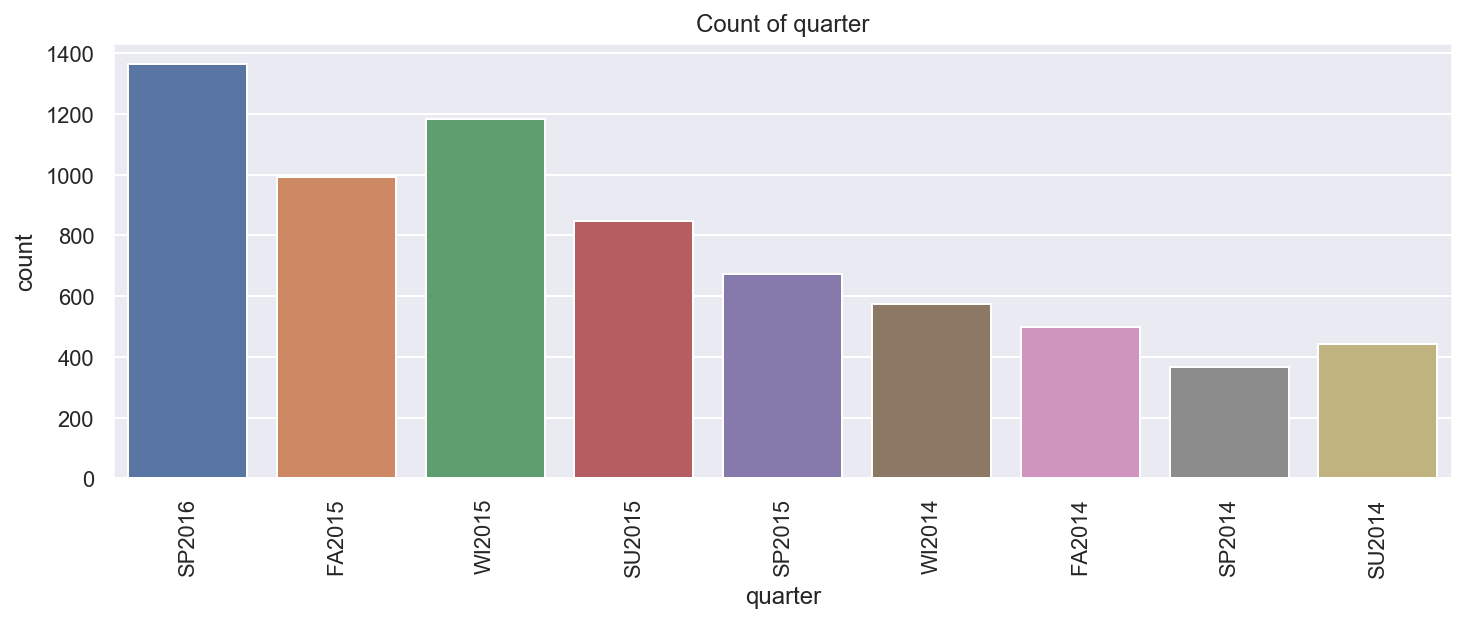

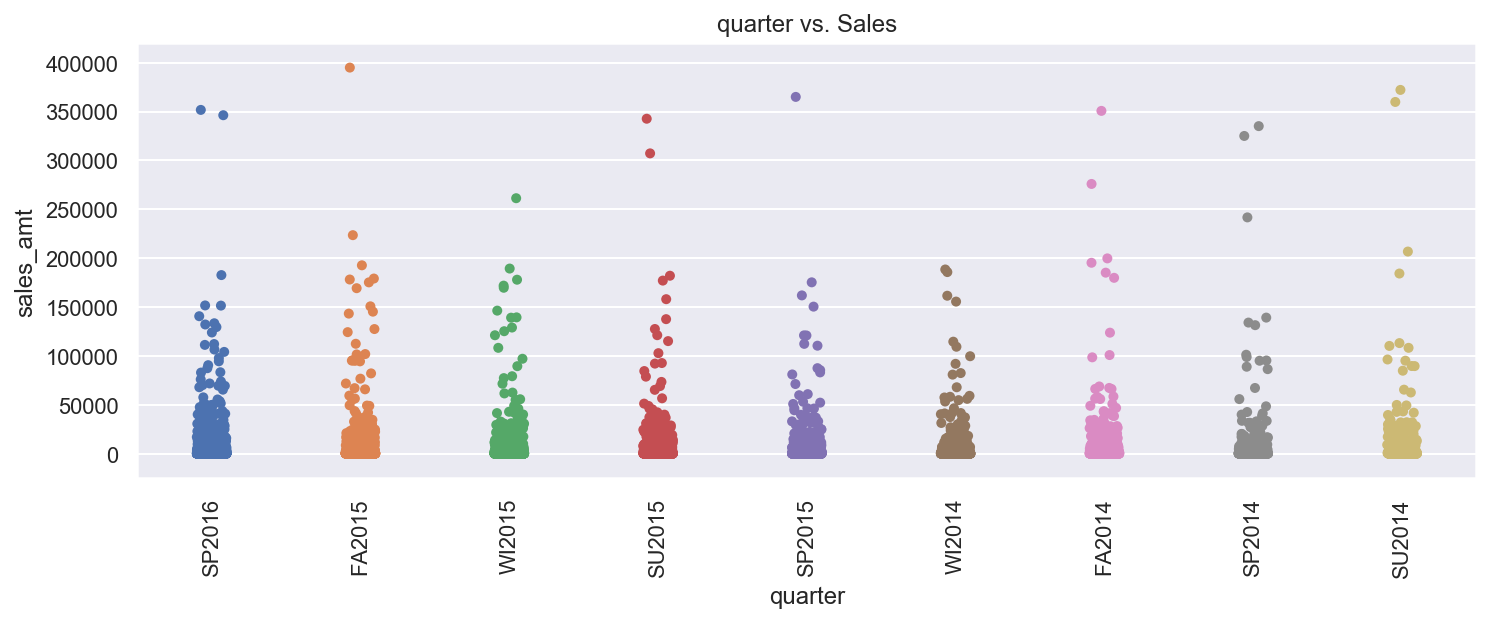

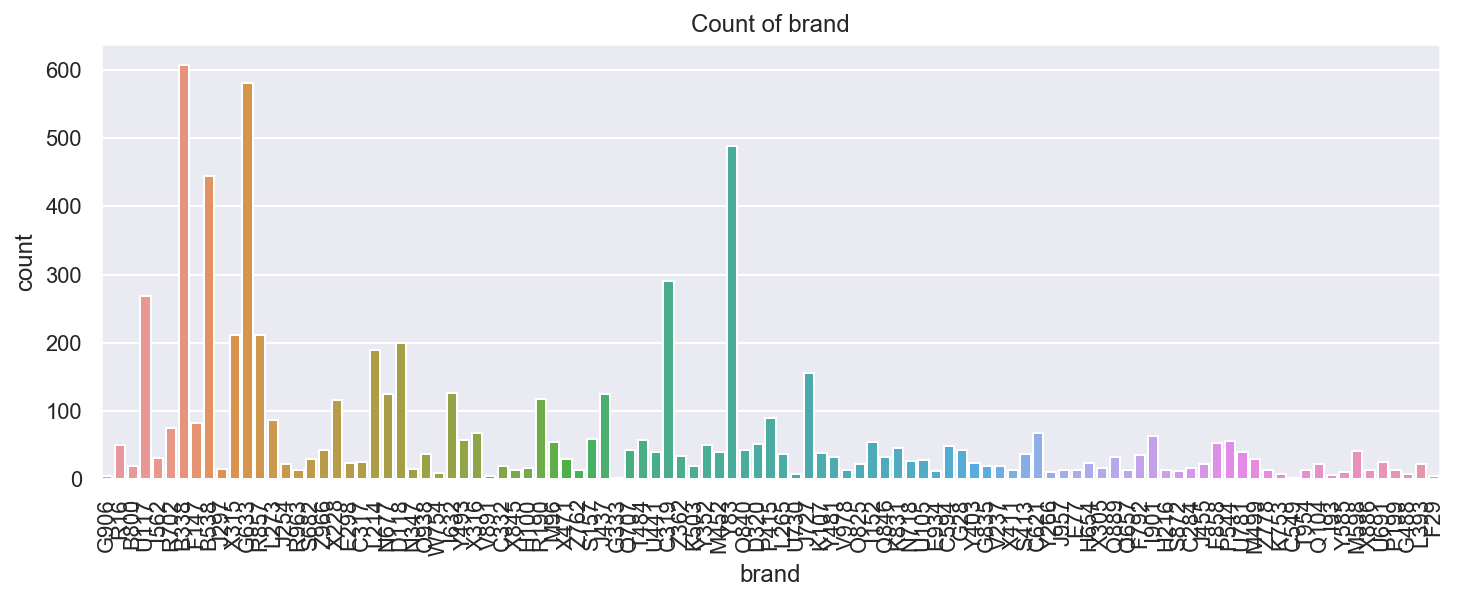

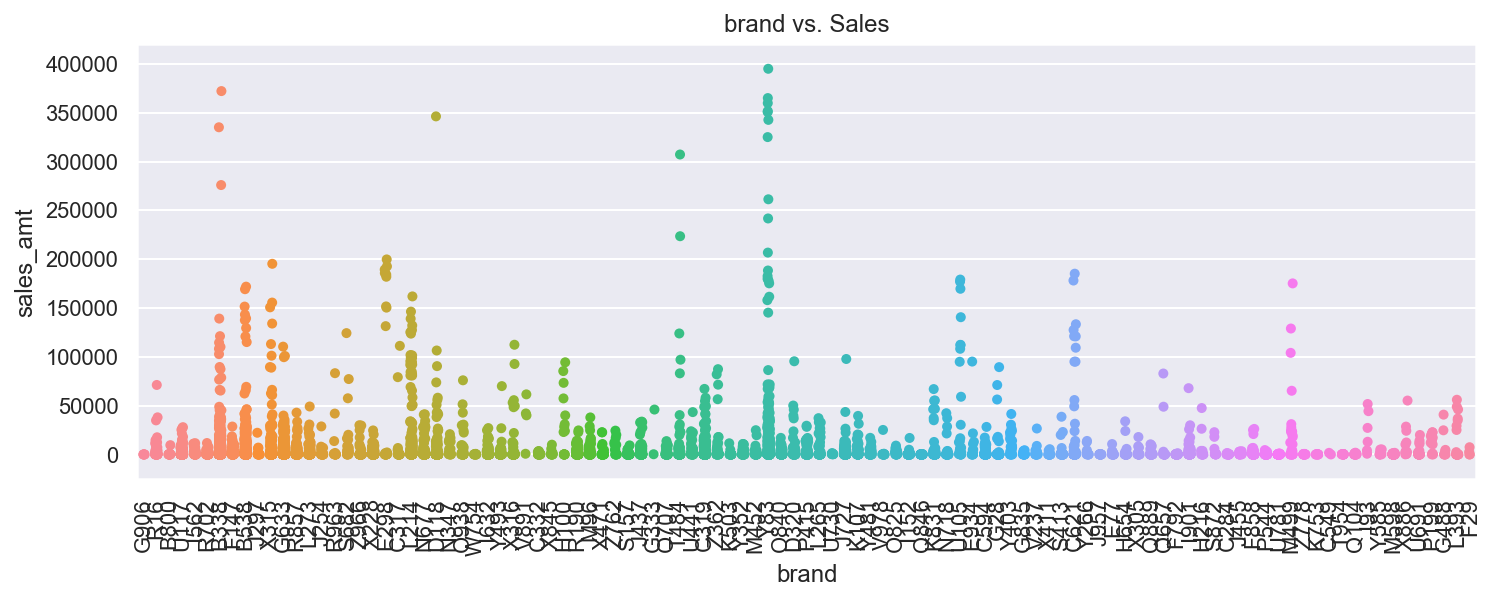

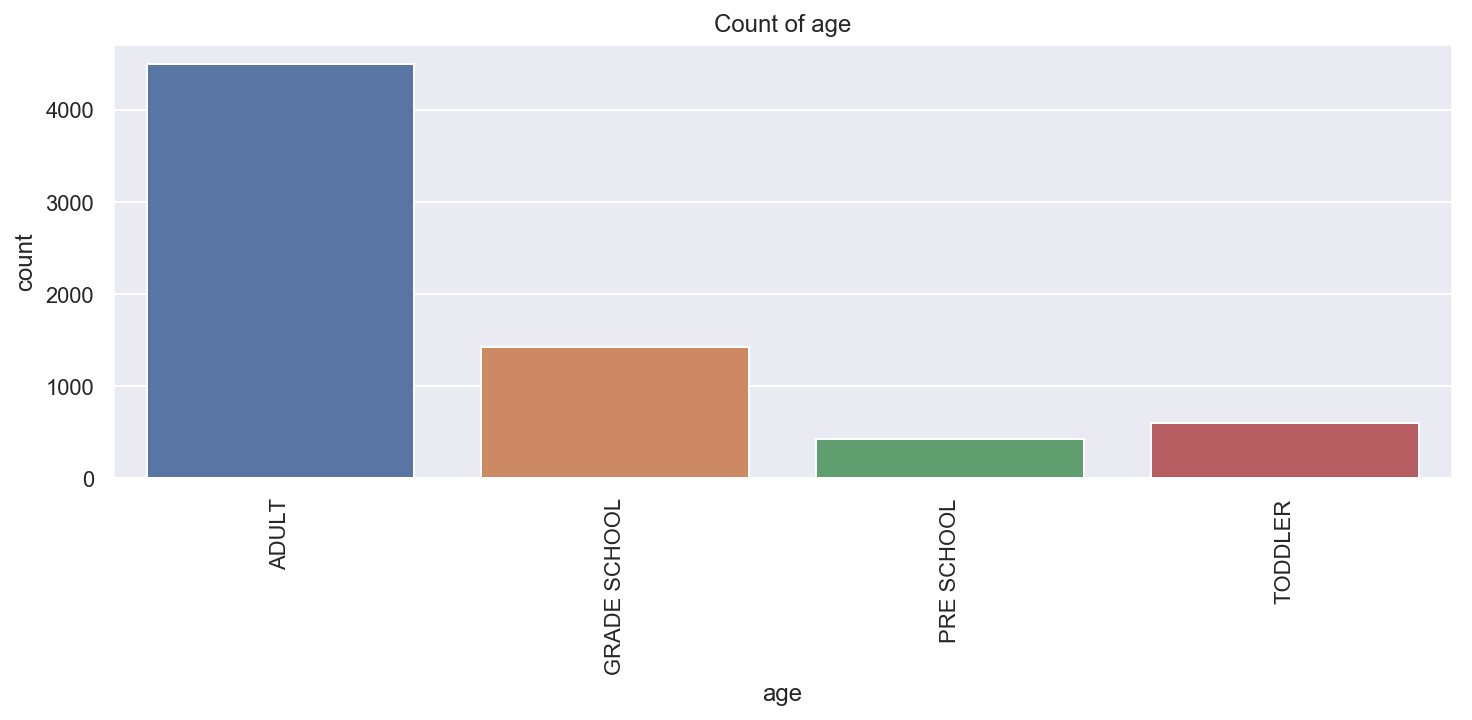

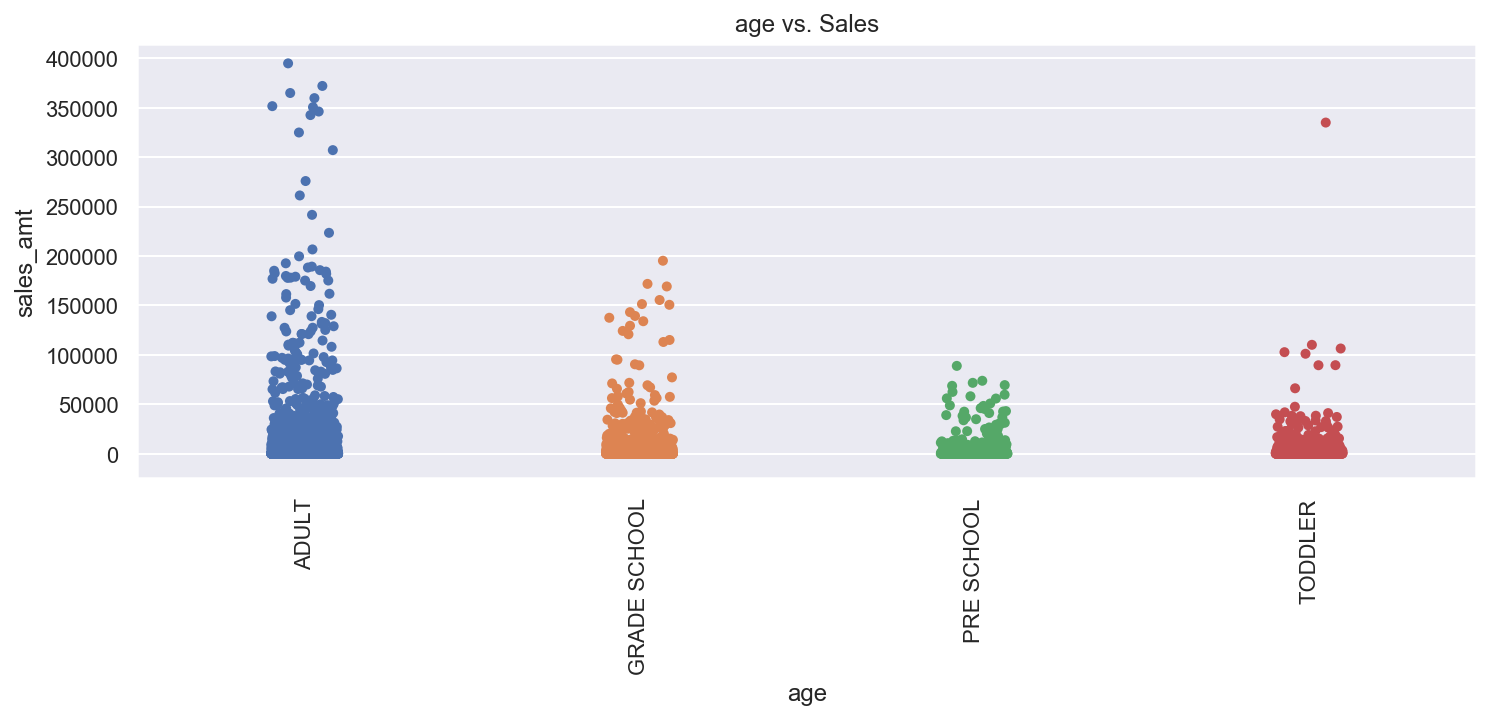

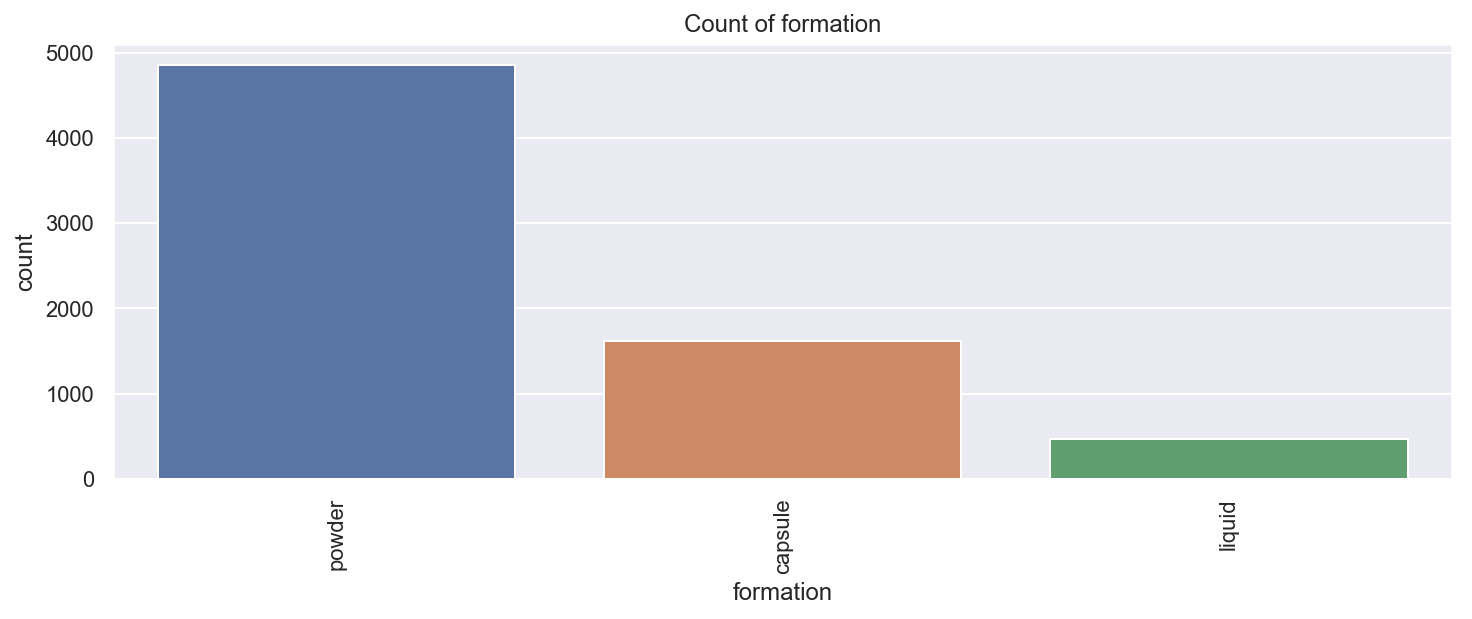

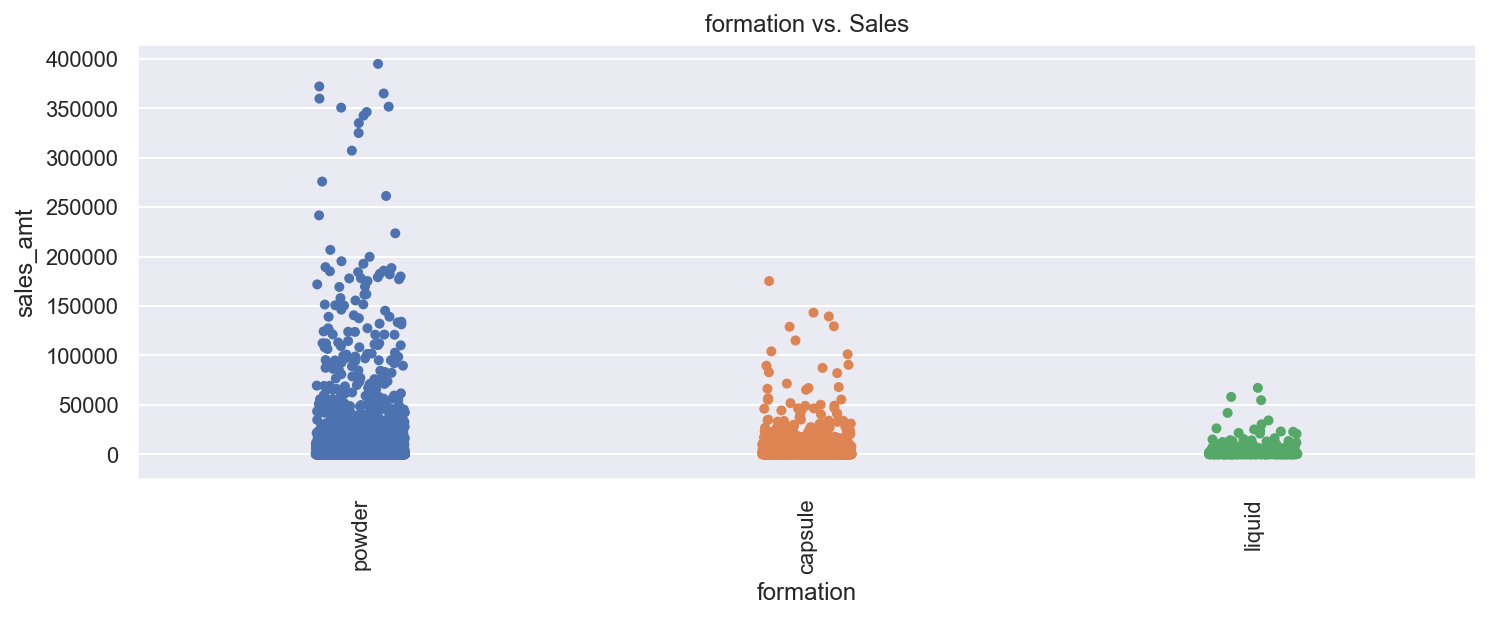

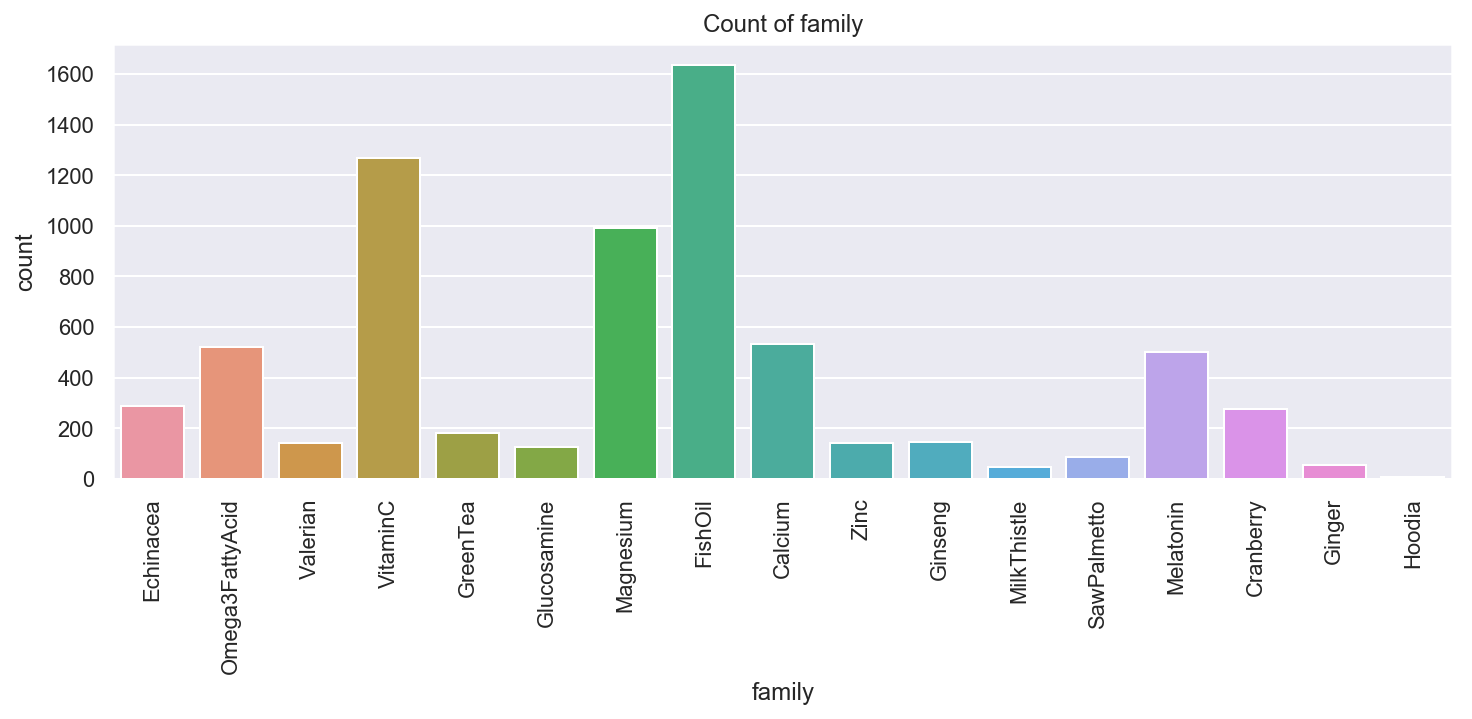

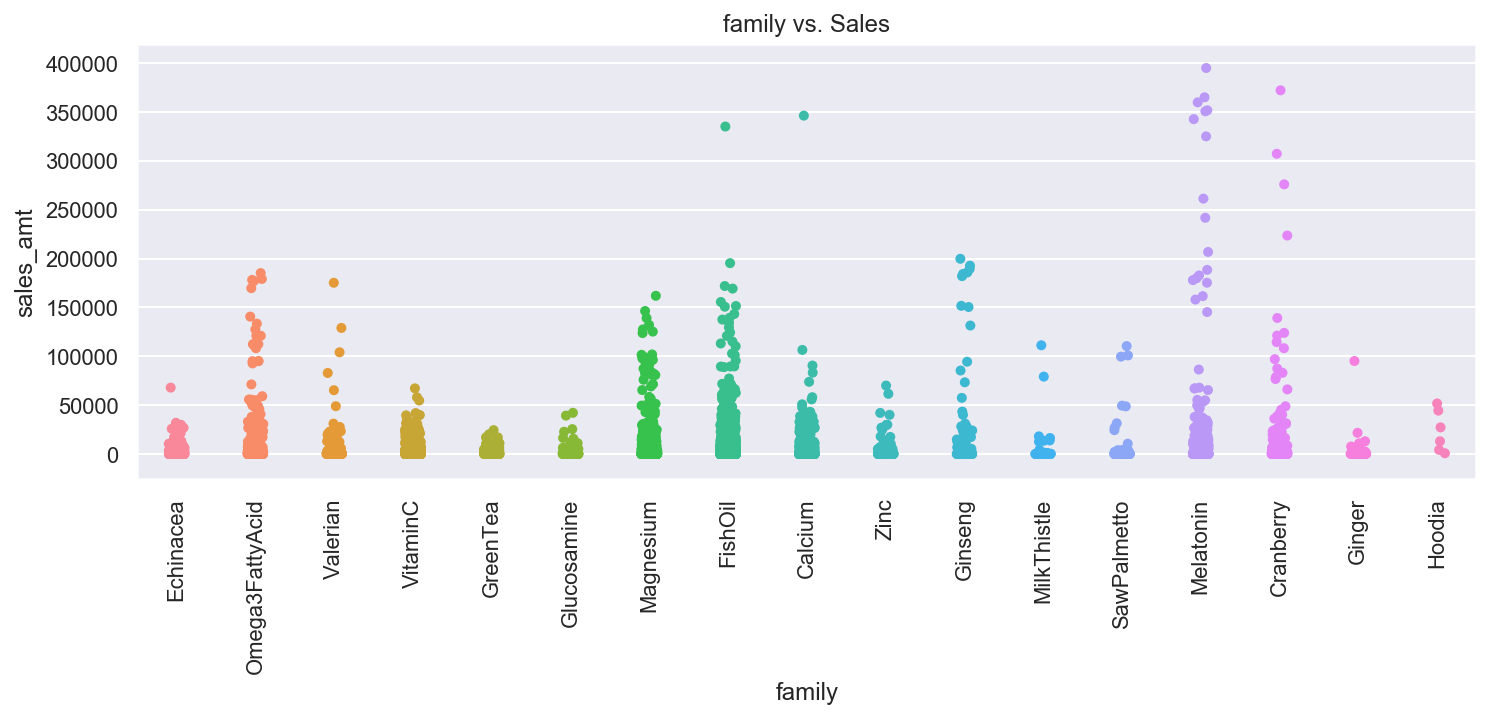

In [39]:
for i in ['location','quarter','brand','age','formation','family']:
    sns.countplot(x=i, data=df_sales_merged)
    plt.xticks(rotation=90)
    plt.title('Count of {}'.format(i))
    plt.show()
    
    sns.stripplot(x=i, y='sales_amt', data=df_sales_merged, jitter=True)
    plt.xticks(rotation=90)
    plt.title('{} vs. Sales'.format(i))
    plt.show()

# Part 2: Feature Engineering

## 2.1 Create new features

### 2.1.1 Extra Season and Year out of quarter

In [49]:
# extract season and year out from the column quarter
df_sales_merged_1 = df_sales_merged.copy(deep = True)

df_sales_merged_1['season'] = df_sales_merged_1['quarter'].astype(str).str[0:2]
df_sales_merged_1['year'] = df_sales_merged_1['quarter'].astype(str).str[2:7]

### 2.1.2 Get tge numnber of patents for each product 

In [63]:
# for table merged sales table
num_specs = df_sales_merged_1['specs'].str.split('|').str.len()
df_sales_merged_1['num_specs'] = num_specs

# apply the treatment in new products as well
new_product_1 = new_product.copy(deep = True)
num_specs_new = new_product_1['specs'].str.split('|').str.len()
new_product_1['num_specs'] = num_specs_new

### 2.1.3 Bucketize sales_price

In [72]:
price = [1, 30, 60, 80, 100, 180, 450]
price_range = ['<=$30', '$30-60','$60-90','$90-120','$120-220','$220-320']

# Bucketize sales_price for carry-over products
price_bin = pd.cut(df_sales_merged_1['sales_price'], price, labels= price_range)
price_seg = pd.get_dummies(price_bin).astype(np.int64)
df_sales_merged_1.drop(['sales_price'], axis = 1, inplace = True)
df_sales_merged_1 = pd.concat([df_sales_merged_1,price_seg], axis = 1)

# Bucketize sales_price for new products 
price_bin_new = pd.cut(new_product_1['sales_price'], price, labels = price_range)
price_seg_new = pd.get_dummies(price_bin_new).astype(np.int64)
new_product_1.drop(['sales_price'], axis = 1, inplace = True)
new_product_1 = pd.concat([new_product_1, price_seg_new], axis = 1)

## 2.2 Scale numerical features

In [77]:
from sklearn import preprocessing

# robust scaling
df_sales_merged_2 = df_sales_merged_1.copy(deep = True)
scale_list = ['shelf_amt','num_specs']
rs_scale = preprocessing.RobustScaler().fit(df_sales_merged_2[scale_list])
df_sales_merged_2[scale_list] = rs_scale.transform(df_sales_merged_2[scale_list])

# Part 3: Model Training and Evaluation

* Two models will be developed: one for carry-over products; one for new products
* The carry over model will be training on only its own historical data
* The new model will be training on the data based on similarity with the new products

## 3.1. Carry-over product model

* Use data of each product to build numerous models is not ideal, the average data point of each product/sku is 22, it is too little to build a good model
* Traditional method such as ARIMA could be used, but it lacks the 'insight' of products inner corrleation
* Build a complicated model using more products is a better option
* Target metric y = sales_amt
* SP2016 data is used to evaluate the model

### 3.1.1 Generate dummy features

In [79]:
cate_list = ['location','brand','age','formation','family','specs','season','year']
df_sales_merged_2 = pd.get_dummies(df_sales_merged_2, columns = cate_list, drop_first=True) 

### 3.1.2 Train and test split

In [82]:
# select ~20% latest data for test purpose
df_sales_merged_2_train = df_sales_merged_2[df_sales_merged_2['quarter'] != 'SP2016']
df_sales_merged_2_test = df_sales_merged_2[df_sales_merged_2['quarter'] == 'SP2016']

In [84]:
from sklearn.utils import shuffle

# prepare training and test data
df_sales_merged_2_train = shuffle(df_sales_merged_2_train)
df_sales_merged_2_train_X = df_sales_merged_2_train.drop(['sku','quarter','sales_amt'], axis = 1)
df_sales_merged_2_train_y = df_sales_merged_2_train['sales_amt'] 

df_sales_merged_2_test_X = df_sales_merged_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
df_sales_merged_2_test_y = df_sales_merged_2_test['sales_amt'] 

### 3.1.3 Quick linear model for baseline

* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

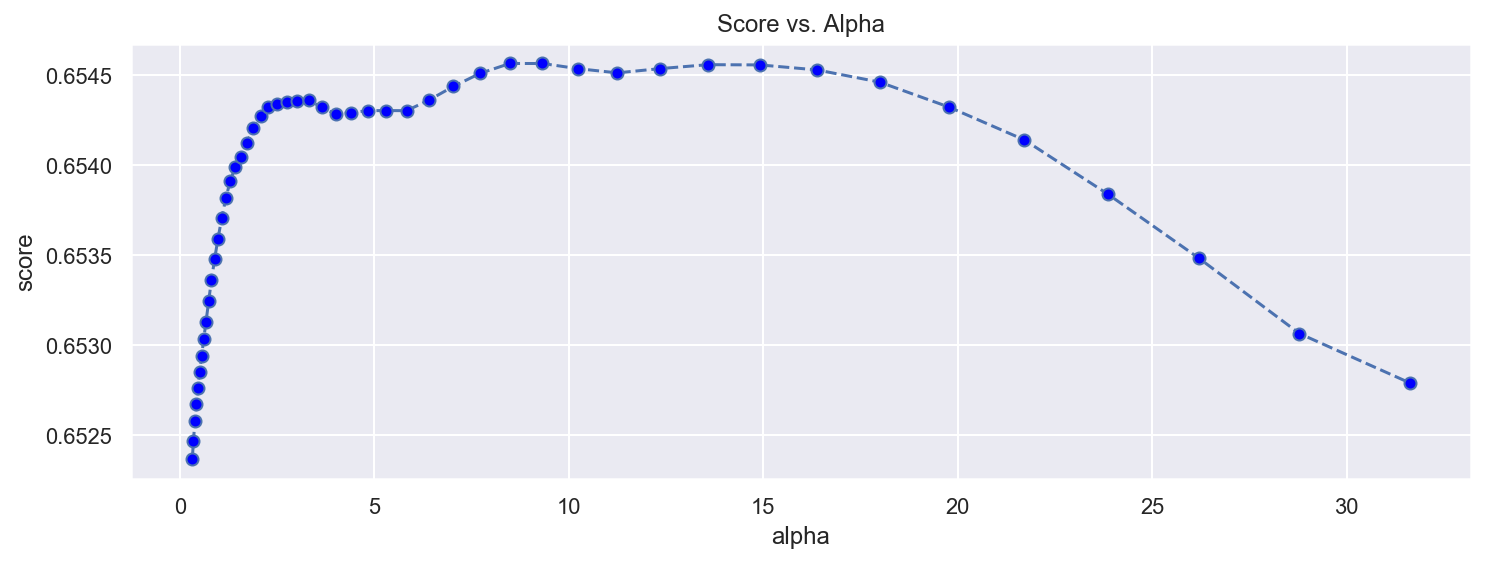

The optimaized alpha and score of Lasso linear is:  8.483428982440717 0.6545646676321009


In [93]:
from sklearn.linear_model import LinearRegression, Lasso

# Lasso model
alphas = np.logspace (-0.5, 1.5, num=50)
scores = np.empty_like(alphas)

opt_a = float('-inf')
max_score = float('-inf')

for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(df_sales_merged_2_train_X, df_sales_merged_2_train_y)
    scores[i] = lasso.score(df_sales_merged_2_test_X, df_sales_merged_2_test_y)
    if scores[i] > max_score: 
        max_score = scores[i]
        opt_a = a
        lasso_saved = lasso

plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('Score vs. Alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [94]:
# use optimal alpha to re-train the model
lasso_optimal = Lasso(alpha = opt_a)
lasso_optimal.fit(df_sales_merged_2_train_X, df_sales_merged_2_train_y)
lasso_pred = lasso_optimal.predict(df_sales_merged_2_test_X)

In [103]:
# compare the aggreated prediction with actual sales
merged_test_lasso = df_sales_merged_2_test.copy(deep=True)
merged_test_lasso['pred'] = np.round(lasso_pred)
merged_test_lasso['pred'] = merged_test_lasso['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
merged_test_lasso_agg = merged_test_lasso.groupby(['sku','quarter'], as_index = False).agg(function_2)

In [127]:
from sklearn.metrics import mean_absolute_error
# define MAPE and MAD_ratio, and evaluation result

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100
                   
def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)
                   
def evaluate(agg_result):
    MAPE = mean_absolute_percentage_error(agg_result['sales_amt'], agg_result['pred'])
    print('MAPE of prediction in September 2016 is {}'.format(MAPE))
    MAE = mean_absolute_error(agg_result['sales_amt'], agg_result['pred'])
    print('MAE of prediction in September 2016 is {}'.format(MAE))
    MAD_ratio = mean_absolute_deviation_ratio(agg_result['sales_amt'], agg_result['pred'])
    print('MAD_ratio of prediction in September 2016 is {}'.format(MAD_ratio))
                   
def plot_diff(agg_result, title_1, title_2):
    plt.plot(agg_result['pred'], marker='o', color = 'red', alpha = 0.3 )
    plt.plot(agg_result['sales_amt'], marker = '*', color ='blue', alpha = 0.5)
    plt.title(title_1)
    plt.legend(loc = 'upper_right')
    plt.show()
                   
    plt.plot((agg_result['pred'] - agg_result['sales_amt']), marker = 'v', color = 'green')
    plt.title(title_2)
    plt.legend(loc = 'upper_right')
    plt.show()

In [128]:
evaluate(merged_test_lasso_agg)

MAPE of prediction in September 2016 is 1556.8355746046545
MAE of prediction in September 2016 is 10421.579937304075
MAD_ratio of prediction in September 2016 is 1.0230542128567328


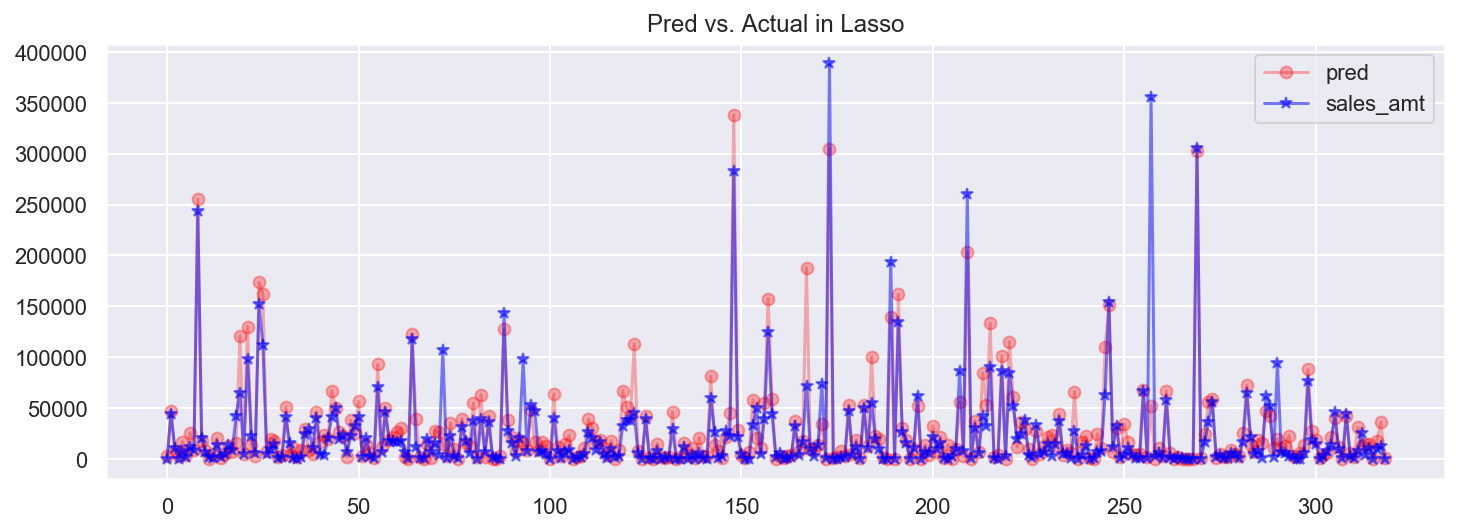

No handles with labels found to put in legend.


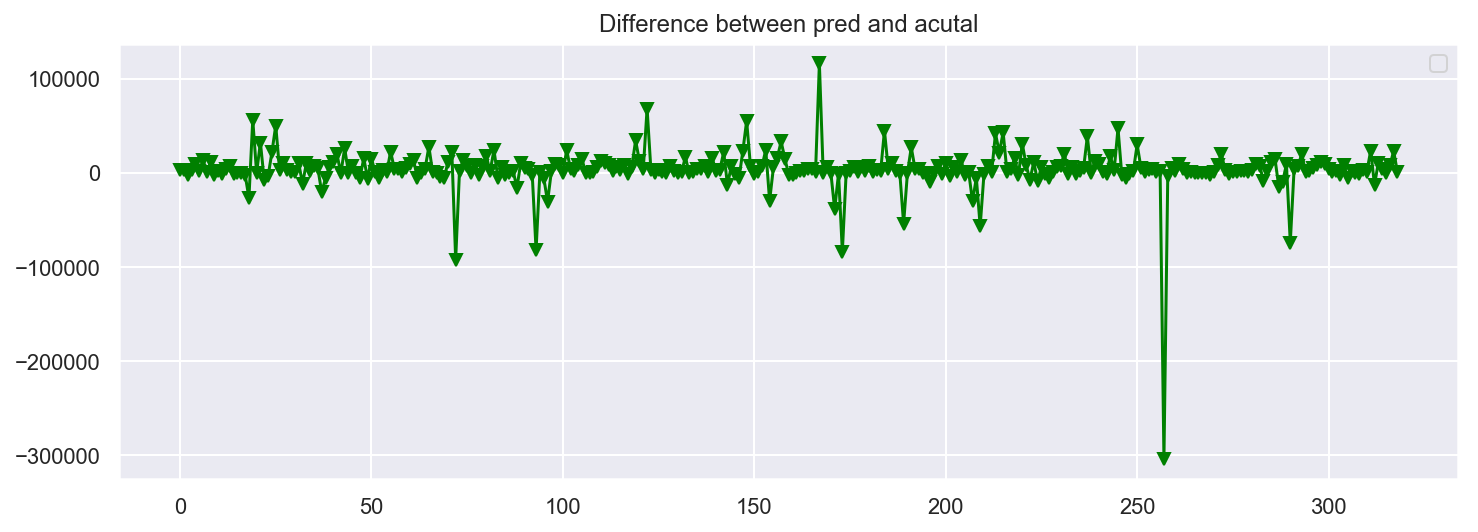

In [126]:
plot_diff(merged_test_lasso_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

### 3.1.4 Random forest model

In [132]:
# plot the hyper-parameter tuning
def class_plot(grid, grid_param, title):
    scores = [x for x in grid.cv_results_['mean_test_score']]
    m_depth = grid_param['max_depth']
    n_est = grid_param['n_estimators']
    scores = np.array(scores).reshape(len(m_depth), len(n_est))
    fig = plt.figure()
    ax = plt.subplot(111)
    for ind, i in enumerate(m_depth):
        plt.plot(n_est, scores[ind], '-o', label='Max depth' + str(i),)
    ax.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5))
    plt.xlabel('n estimator')
    plt.ylabel('Mean score')
    plt.title(title)
    plt.show()
    

# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance, left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

grid_1 = {'n_estimators': [5,10,15,20,30,40,50], 'max_depth': [30,40,45,50,55,60,70]}
rf_1 = RandomForestRegressor(random_state=2020, verbose=1, n_jobs =6)
grid_rf_1 = GridSearchCV(estimator = rf_1, param_grid = grid_1, cv=5)
grid_rf_1.fit(df_sales_merged_2_train_X, df_sales_merged_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=6,
           oob_score=False, random_state=2020, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 40, 50], 'max_depth': [30, 40, 45, 50, 55, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [130]:
print (grid_rf_1.best_params_)
print (grid_rf_1.best_score_)

{'max_depth': 45, 'n_estimators': 30}
0.8773534250776445


In [131]:
# re-train the model with full training set
rf_best = grid_rf_1.best_estimator_
rf_best.fit(df_sales_merged_2_train_X, df_sales_merged_2_train_y)
pred_rf_test = rf_best.predict(df_sales_merged_2_test_X)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


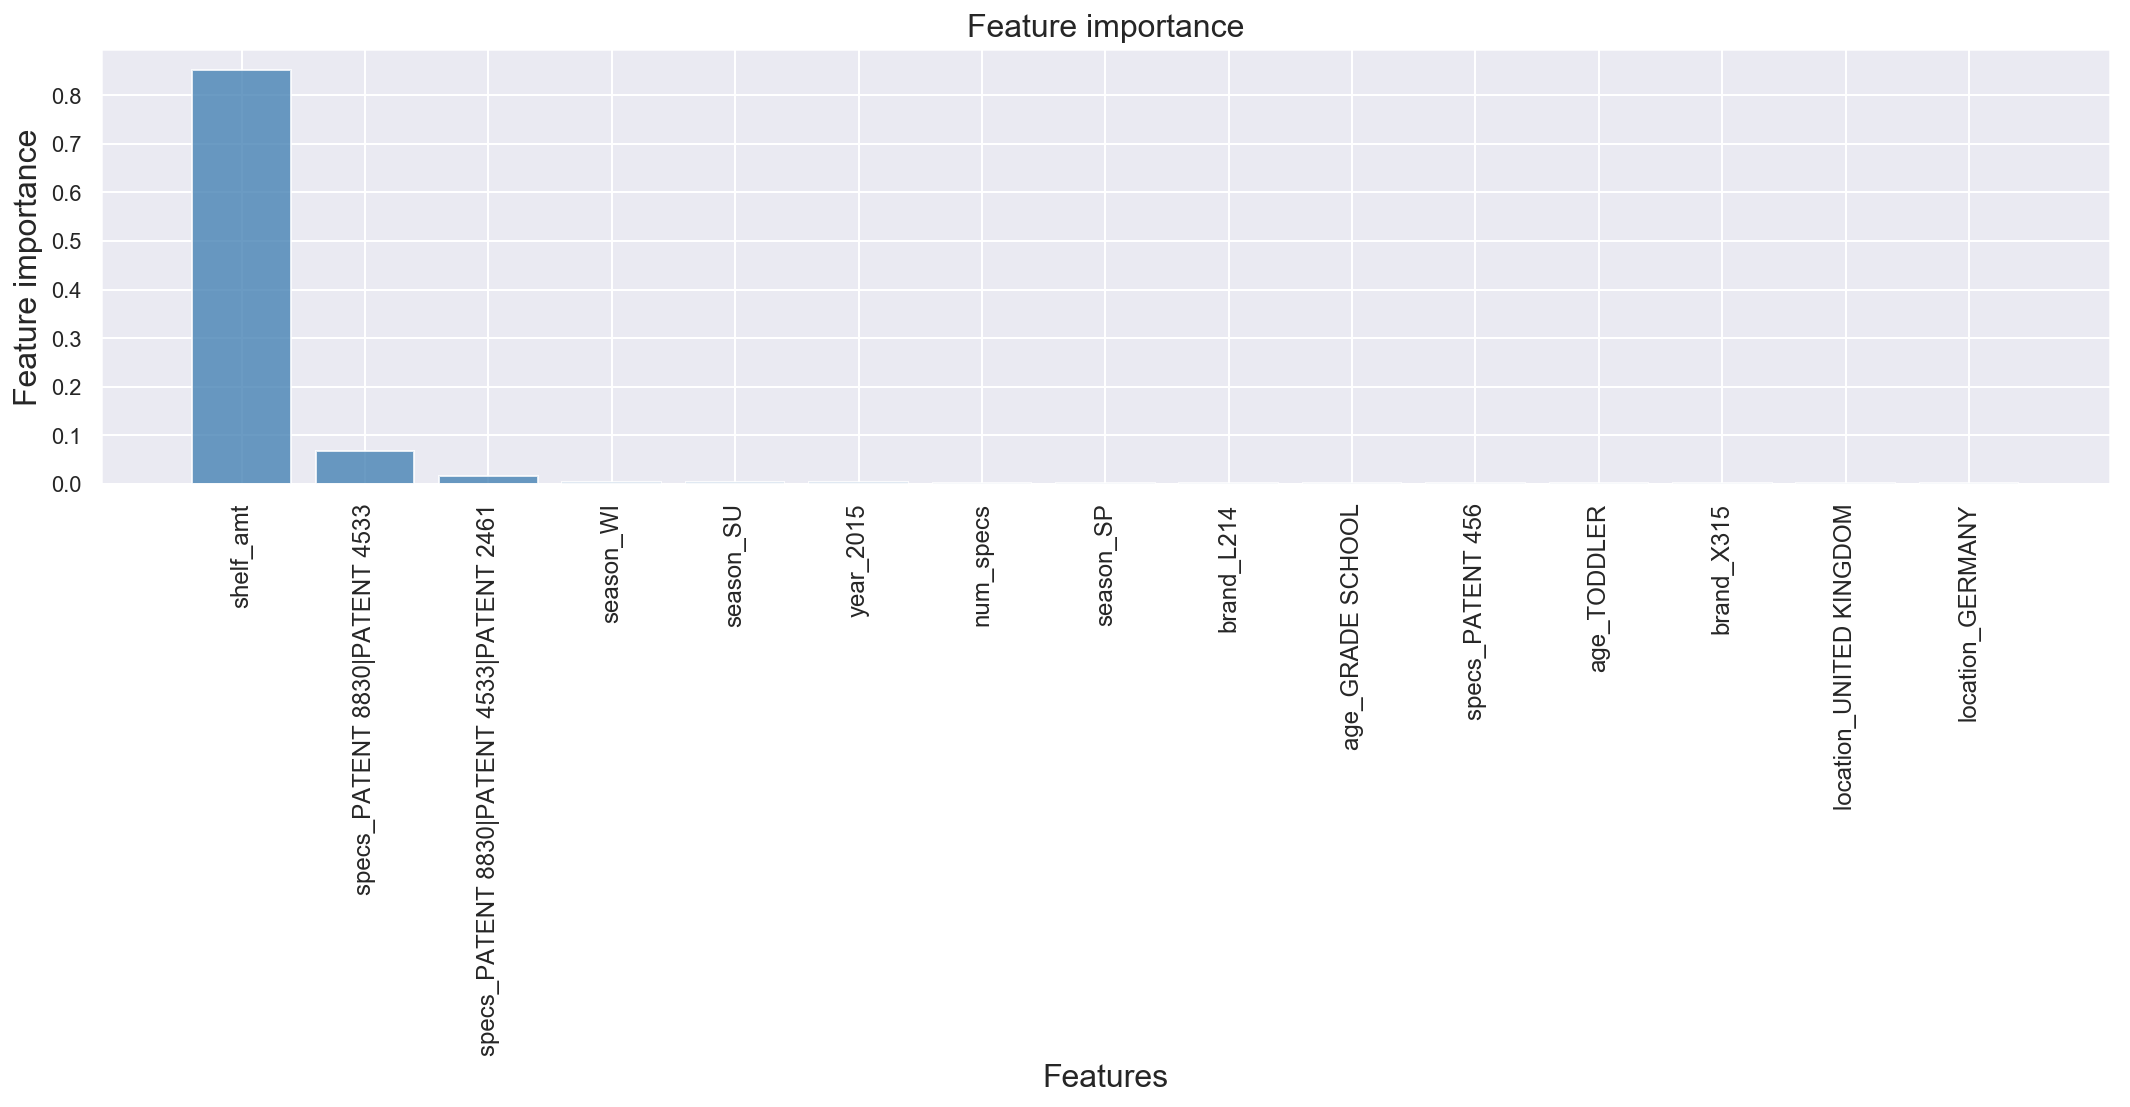

In [134]:
importance_rf_best = rf_best.feature_importances_
names_rf_best = df_sales_merged_2_train_X.columns.tolist()
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})

# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)
plot_feature_importance(rank_importance_rf_best, 15, 'steelblue', 0.8, 18, 4, 'Feature importance')

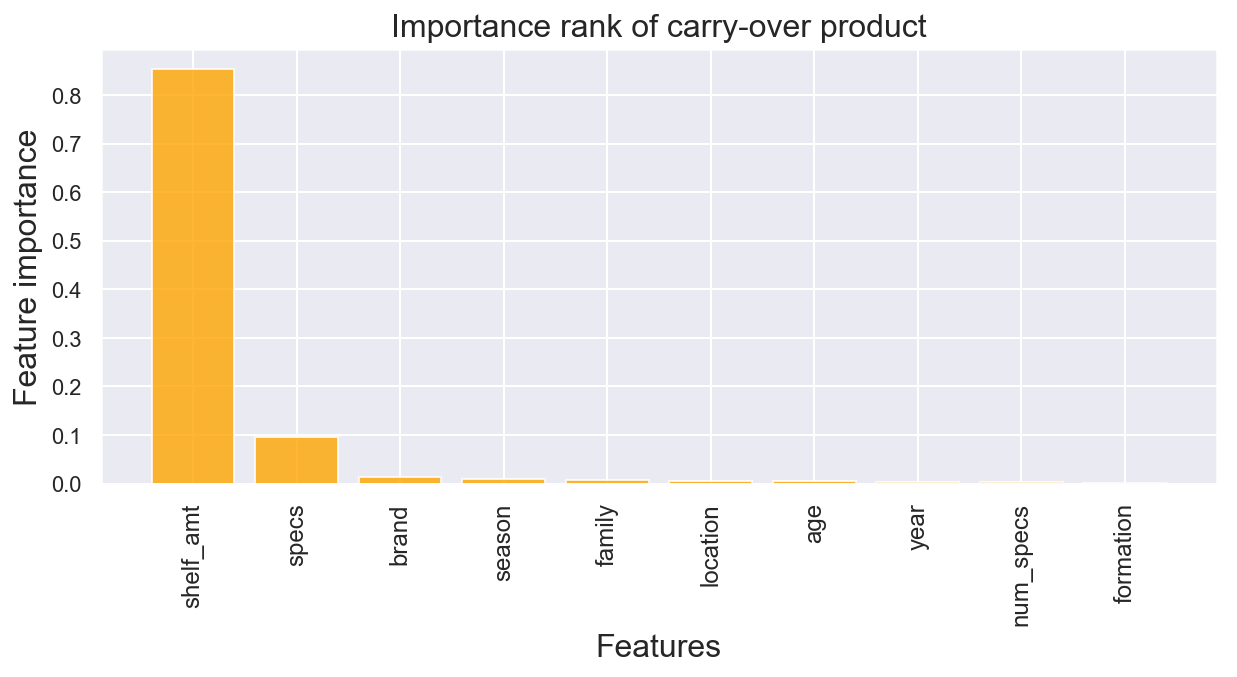

In [135]:
# plot feature importance ranking of original feature (before dummies)
raw_feature_importances_rf_best = raw_feature_importance(df_importantce_rf_best,2,cate_list)
plot_feature_importance(raw_feature_importances_rf_best, 21, 'orange', 0.8, 10, 4, 
                        'Importance rank of carry-over product')

In [136]:
# compare the aggreated prediction with actual sales
merged_test_rf = df_sales_merged_2_test.copy(deep=True)
merged_test_rf['pred'] = np.round(pred_rf_test)
merged_test_rf['pred'] = merged_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
merged_test_rf_agg = merged_test_rf.groupby(['sku','quarter'],as_index = False).agg(function_2)

In [137]:
evaluate(merged_test_rf_agg)

MAPE of prediction in September 2016 is 95.64343408687432
MAE of prediction in September 2016 is 8493.445141065831
MAD_ratio of prediction in September 2016 is 0.9719344734105044


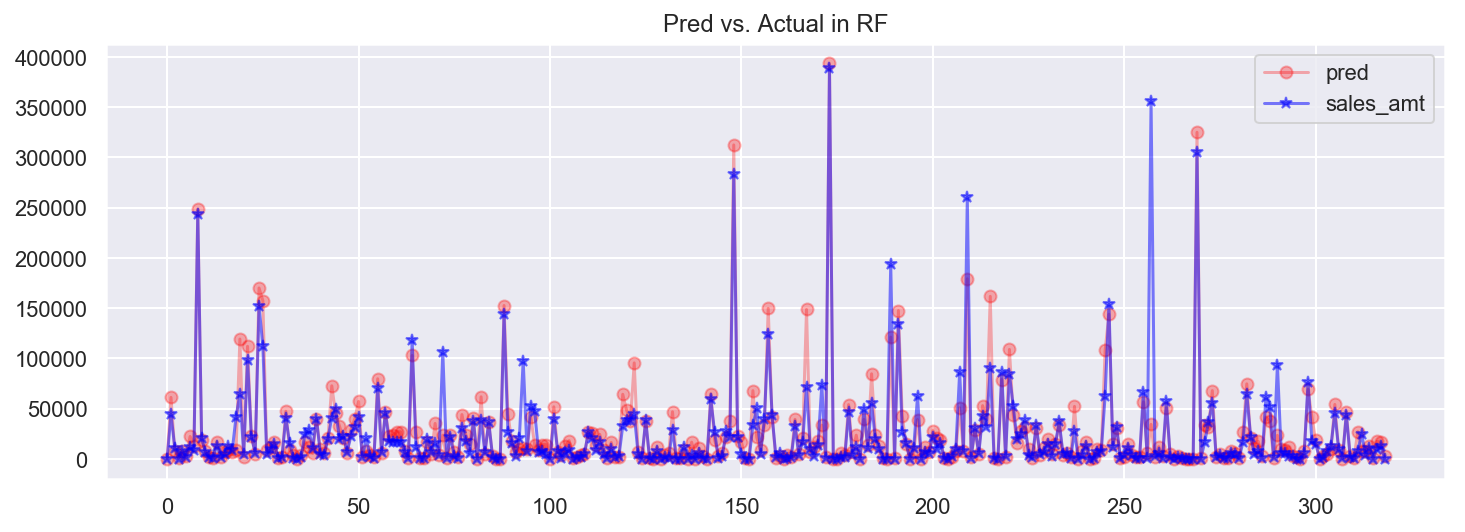

No handles with labels found to put in legend.


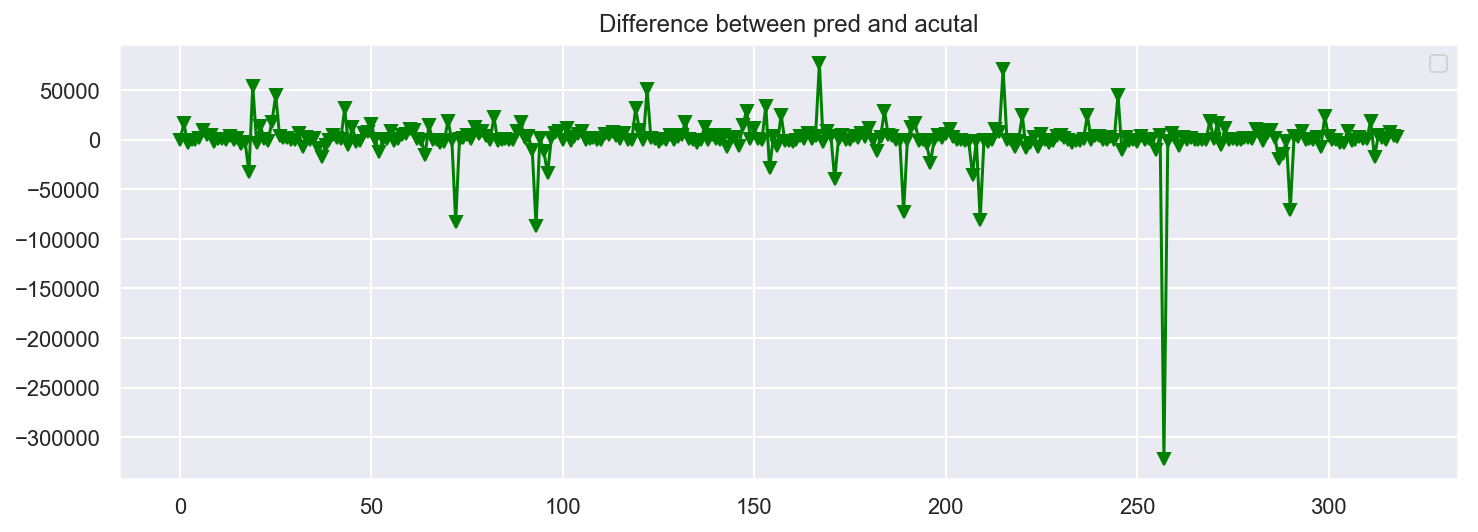

In [138]:
plot_diff(merged_test_rf_agg, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

In [139]:
# re-train with training + test data, save model for future prediction
co_combine_3 = co_combine_2.copy(deep =True)
co_combine_3 = shuffle(co_combine_3)
co_combine_3_X = co_combine_3.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_3_y = co_combine_3['sales_amt'] 

rf_best.fit(co_combine_3_X,co_combine_3_y)

# save model
joblib.dump(rf_best, 'rf_best_co.sav', compress=3)

NameError: name 'co_combine_2' is not defined

## 3.2 New product model

* The product is new and has not been sold before.
* Find a group of old products similiar to the new product, train a model on them, and use this model for prediction
* Clustering could be another method, number of clusters can be a hyper-parameter

### 3.2.1 Similar product search

* Analyze the cosine similarity between 87 new products in new_product_1 and 320 products in df_sales_merged_1 with full historical data
* For each new product, the top 3 most similar old products are chosen
* Then use the data of these chosen carry-over products to train a model, which can predict demand of new products

In [141]:
similarity_prod = df_sales_merged_1[['sku','brand','age','formation','family','specs','num_specs','<=$30', 
                                     '$30-60','$60-90','$90-120','$120-220','$220-320']]

cate_similarity = ['brand','age','formation','family','specs']
                   
similarity_prod_dummy = pd.get_dummies(similarity_prod, columns=cate_similarity, drop_first=True) 

# get unique rows for cosine similarity compare
similarity_prod_dummy.drop_duplicates(inplace = True)

# this is is later ID mapping
prod_ID = similarity_prod_dummy['sku']
s_list = similarity_prod_dummy.drop(['sku'],axis=1).values.tolist()

In [142]:
new_prod_dummy = pd.get_dummies(new_product_1, columns=cate_similarity, drop_first=True) 

In [143]:
# make the same column in whole data and new product data
diff_sim = list((set(new_prod_dummy.columns) - set(similarity_prod_dummy.columns)))

if len(diff_sim)!=0:
    new_prod_dummy.drop(diff_sim, axis = 1, inplace =True)

missing_cols_sim = set(similarity_prod_dummy.columns) - set(new_prod_dummy.columns)

# Add a missing column in test set with default value equal to 0
for m in missing_cols_sim:
    new_prod_dummy[m] = 0
    
new_prod_dummy = new_prod_dummy[similarity_prod_dummy.columns]

# get unique rows for cosine similarity compare
new_prod_dummy.drop_duplicates(inplace = True)
new_prod_ID = new_prod_dummy['sku']

s_new = new_prod_dummy.drop(['sku'], axis=1)
s_new_list = s_new.values.tolist()

In [146]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# a special dict to have list as key, to keep order
# get the similarity between 87 new products and 320 carry-over products
d_sim = defaultdict(list)

for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1,-1)
        s_list[j] = np.array(s_list[j]).reshape(1,-1)
        tmp_sim = float(cosine_similarity(s_new_list[i],s_list[j]))
        d_sim[i].append(tmp_sim)

In [147]:
len(d_sim)

87

In [148]:
# get the top 3 most similar products list with each new product
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]
# high_sim_prod_ID.tolist()

### 3.2.2 Training/testing data for new product

In [157]:
similar_new_1 = df_sales_merged_1[df_sales_merged_1['sku'].isin(high_sim_prod_ID)]
print( similar_new_1.shape)
similar_new_2 = pd.get_dummies(similar_new_1,columns=cate_list,drop_first=True) 

(3447, 19)


In [158]:
# select ~20% latest data for test purpose
similar_new_2_test = similar_new_2[similar_new_2['quarter'] =='SP2016']
similar_new_2_train = similar_new_2[similar_new_2['quarter'] !='SP2016']

# prepare training and test data
similar_new_2_train = shuffle(similar_new_2_train)
similar_new_2_train_X = similar_new_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_train_y = similar_new_2_train['sales_amt'] 

similar_new_2_test_X = similar_new_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_test_y = similar_new_2_test['sales_amt'] 

### 3.2.3 Random forest model

In [159]:
grid_2 = {'n_estimators': [15,20,30,40,50,60,70,80],
          'max_depth': [5,10,20,30,40,50]}

rf_2 = RandomForestRegressor(random_state=2019, verbose=1,n_jobs =6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv=3)
grid_rf_2.fit(similar_new_2_train_X, similar_new_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    3.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using ba

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=6,
           oob_score=False, random_state=2019, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [15, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

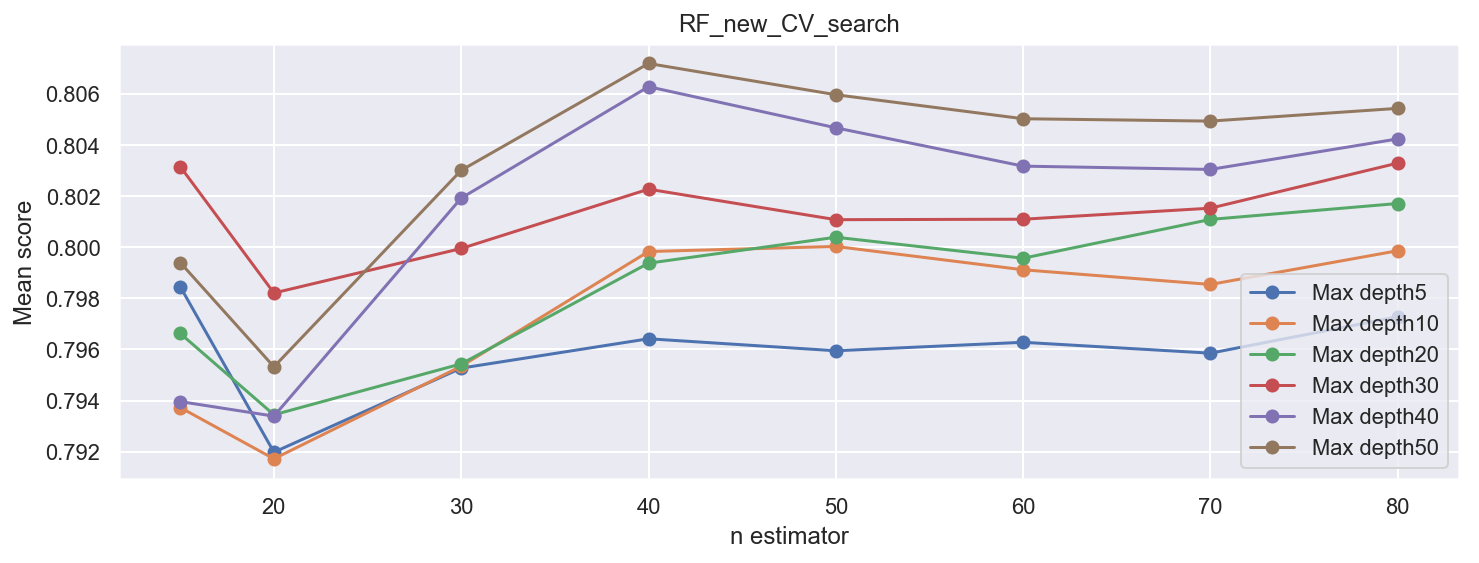

{'max_depth': 50, 'n_estimators': 40}
0.8071852420371514


In [160]:
class_plot(grid_rf_2, grid_2, 'RF_new_CV_search')
print (grid_rf_2.best_params_)
print (grid_rf_2.best_score_)

In [162]:
from sklearn.externals import joblib

# re-train the model with full training set
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similar_new_2_train_X, similar_new_2_train_y)
# save model
joblib.dump(rf_best_new, 'rf_best_new.sav', compress=3)

pred_rf_test_new = rf_best_new.predict(similar_new_2_test_X)

# compare the aggreated prediction with actual sales
new_test_rf = similar_new_2_test.copy(deep=True)
new_test_rf['pred'] = np.round(pred_rf_test_new)
new_test_rf['pred'] = new_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
new_test_rf_agg = new_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished


In [163]:
evaluate(new_test_rf_agg)

MAPE of prediction in September 2016 is 108.72775226785171
MAE of prediction in September 2016 is 10008.104294478528
MAD_ratio of prediction in September 2016 is 0.895292277581138


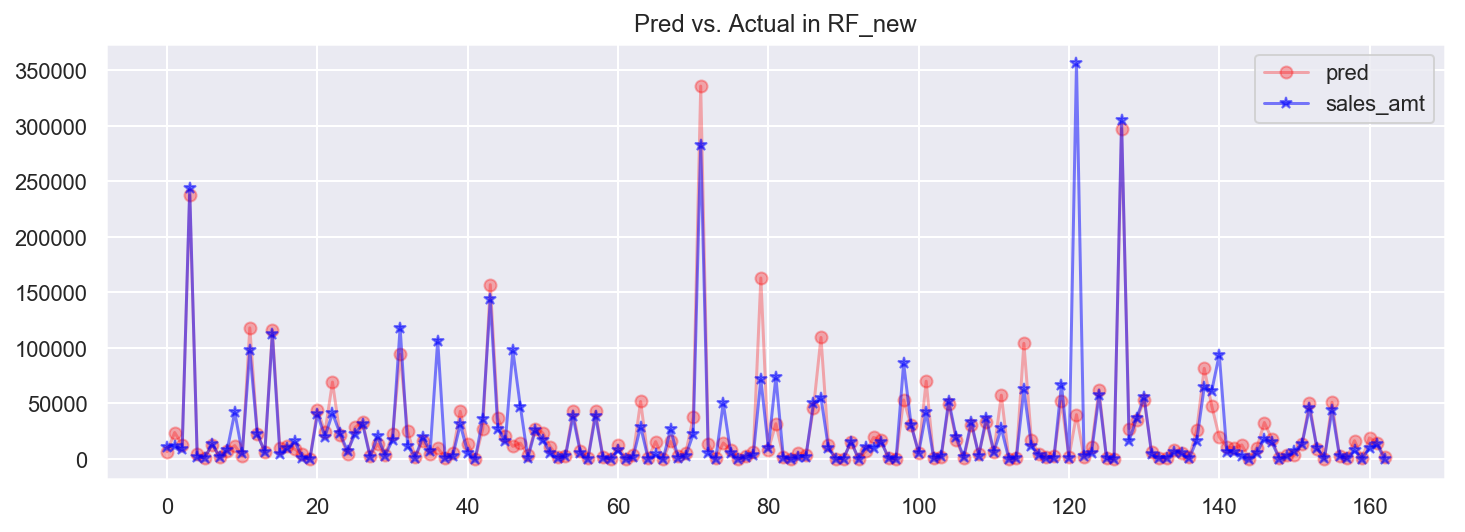

No handles with labels found to put in legend.


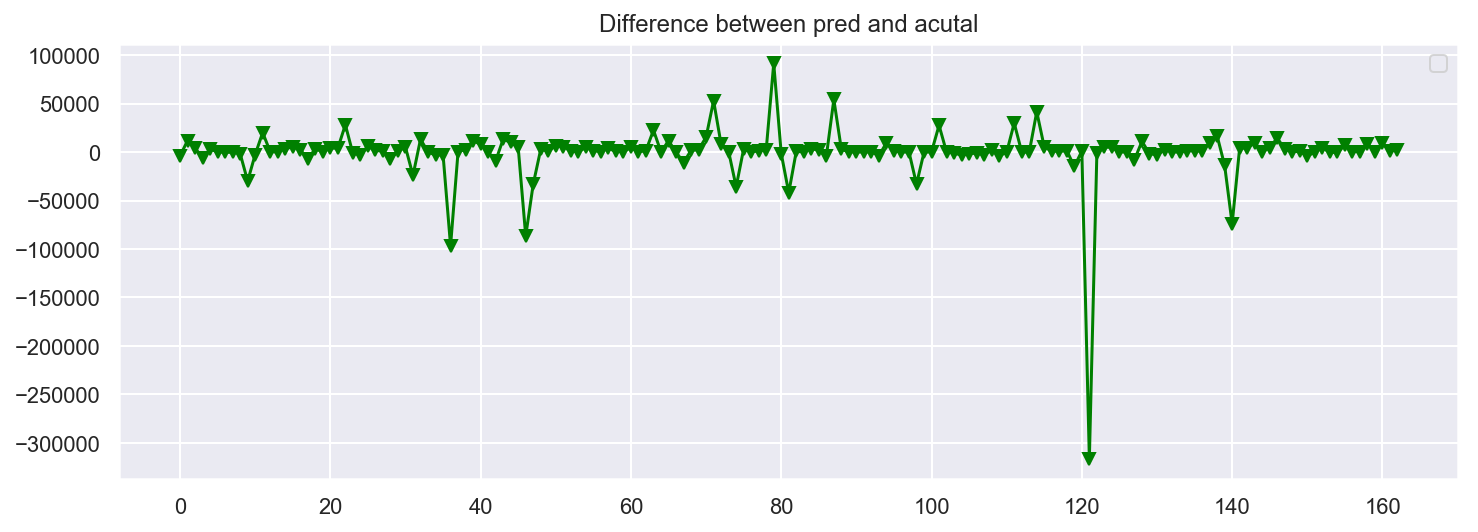

In [164]:
plot_diff(new_test_rf_agg, 'Pred vs. Actual in RF_new', 'Difference between pred and acutal')

# Part 4: Prediction